In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
file_path = 'healthcare-dataset-stroke-data.csv'
stroke_data = pd.read_csv(file_path)

# Handling missing values and encoding categorical variables
stroke_data['bmi'].fillna(stroke_data['bmi'].median(), inplace=True)
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for column in categorical_columns:
    stroke_data[column] = LabelEncoder().fit_transform(stroke_data[column])

# Splitting the data into features and target variable
X = stroke_data.drop(['stroke', 'id'], axis=1)
y = stroke_data['stroke']

# Applying SMOTE for handling class imbalance
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [3]:
# Sigmoid function for Logistic Regression and SGD
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) # Sigmoid = 1 / (1 + exp(-z))

# Custom Logistic Regression
def train_logistic_regression(X, y, lr=0.01, epochs=1000):
    weights = np.zeros(X.shape[1])
    for _ in range(epochs):
        predictions = sigmoid(np.dot(X, weights))
        weights -= lr * np.dot(X.T, predictions - y) / len(y) # Gradient Descent
    return weights

def predict_logistic_regression(X, weights):
    return (sigmoid(np.dot(X, weights)) >= 0.5).astype(int) # Predicting the class

In [4]:
# Custom Stochastic Gradient Descent (SGD)
def train_sgd(X, y, lr=0.01, epochs=1000):
    weights = np.zeros(X.shape[1])
    for _ in range(epochs):
        for i in range(len(y)):
            idx = np.random.randint(len(y))
            X_i = X[idx, :]
            y_i = y[idx]
            predictions = sigmoid(np.dot(X_i, weights))
            weights -= lr * np.dot(X_i.T, predictions - y_i) # Stochastic Gradient Descent
    return weights

def predict_sgd(X, weights):
    return (sigmoid(np.dot(X, weights)) >= 0.5).astype(int)

In [5]:
#Performance metrics
def calculate_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def calculate_precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives > 0 else 0

def calculate_recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives > 0 else 0

def calculate_f1_score(y_true, y_pred):
    precision = calculate_precision(y_true, y_pred)
    recall = calculate_recall(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def calculate_roc_auc(y_true, y_pred):
    #Converting y_true to numpy array
    y_true = y_true.values

    # Sort scores and corresponding truth values
    sorted_indices = np.argsort(y_pred)[::-1]
    y_true_sorted = y_true[sorted_indices]

    # Calculate the true positive and false positive rates
    tpr = []
    fpr = []
    cum_pos = (y_true_sorted == 1).cumsum()
    cum_neg = (y_true_sorted == 0).cumsum()
    total_pos = cum_pos[-1]
    total_neg = cum_neg[-1]

    for i in range(len(y_pred)):
        tpr.append(cum_pos[i] / total_pos if total_pos else 0)
        fpr.append(cum_neg[i] / total_neg if total_neg else 0)

    # Add (0,0) at the beginning and (1,1) at the end for complete curve
    tpr = [0] + tpr + [1]
    fpr = [0] + fpr + [1]

    # Compute Area Under the Curve (AUC) using the trapezoidal rule
    roc_auc = np.trapz(tpr, fpr)
    return roc_auc


In [6]:
#10 fold cross validation function
def cross_validate_model(model, X, y):
    kf = KFold(n_splits=10, shuffle=True)
    accuracy, precision, recall, f1, auc = [], [], [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if(model == LogisticRegression()):
            weights = train_logistic_regression(X_train, y_train)
            y_pred = predict_logistic_regression(X_test, weights)
        elif(model == SGDClassifier()):
            weights = train_sgd(X_train, y_train)
            y_pred = predict_sgd(X_test, weights)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        accuracy.append(calculate_accuracy(y_test, y_pred))
        precision.append(calculate_precision(y_test, y_pred))
        recall.append(calculate_recall(y_test, y_pred))
        f1.append(calculate_f1_score(y_test, y_pred))
        auc.append(calculate_roc_auc(y_test, y_pred))

    scores = {
        'Accuracy': np.mean(accuracy),
        'Precision': np.mean(precision),
        'Recall': np.mean(recall),
        'F1 Score': np.mean(f1),
        'AUC': np.mean(auc)
    }
    return scores

In [7]:
# Define models
models = {
    "NB": GaussianNB(),
    "LR": LogisticRegression(),
    "RF": RandomForestClassifier(),
    "GradBoost": GradientBoostingClassifier(), 
    "SGD": SGDClassifier(),
    "KNN": KNeighborsClassifier(),
    "DT": DecisionTreeClassifier(),
    "SVM_RBF": SVC(kernel='rbf'),
    "MLP": MLPClassifier(),
    "Voting": VotingClassifier(
        estimators=[('nb', GaussianNB()), ('rf', RandomForestClassifier()), 
                    ('lr', LogisticRegression())],
        voting='hard'
    ),
    "Stacking": StackingClassifier(
        estimators=[('nb', GaussianNB()), ('rf', RandomForestClassifier()), 
                    ('dt_j48', DecisionTreeClassifier(criterion='gini')), 
                    ('dt_reptree', DecisionTreeClassifier(criterion='gini'))],
        final_estimator=LogisticRegression()
    )
}

In [8]:
# Evaluating each model
results = {name: cross_validate_model(model, X_resampled, y_resampled) for name, model in models.items()}

# Display results
for model_name, performance in results.items():
    print(f"{model_name}: {performance}")

NB: {'Accuracy': 0.7865655623649228, 'Precision': 0.7517641078431081, 'Recall': 0.85617647067166, 'F1 Score': 0.8003868736143964, 'AUC': 0.7454882750483864}
LR: {'Accuracy': 0.8023049285439374, 'Precision': 0.7889303278466162, 'Recall': 0.8258632117176369, 'F1 Score': 0.8068492433157285, 'AUC': 0.7725144253820672}
RF: {'Accuracy': 0.9480566869255919, 'Precision': 0.9319598450197397, 'Recall': 0.9666956035010467, 'F1 Score': 0.948992747876711, 'AUC': 0.9360803569434057}
GradBoost: {'Accuracy': 0.8725567693992954, 'Precision': 0.8500758109109097, 'Recall': 0.9046973998165015, 'F1 Score': 0.8764226055020797, 'AUC': 0.8476590843383175}
SGD: {'Accuracy': 0.7375076658250119, 'Precision': 0.7787834171490557, 'Recall': 0.7080183208189117, 'F1 Score': 0.7123943531887535, 'AUC': 0.6419884050436103}
KNN: {'Accuracy': 0.89138118076967, 'Precision': 0.8325893635908683, 'Recall': 0.979989329567162, 'F1 Score': 0.9002421762980036, 'AUC': 0.8622099569078981}
DT: {'Accuracy': 0.9129807265298873, 'Preci

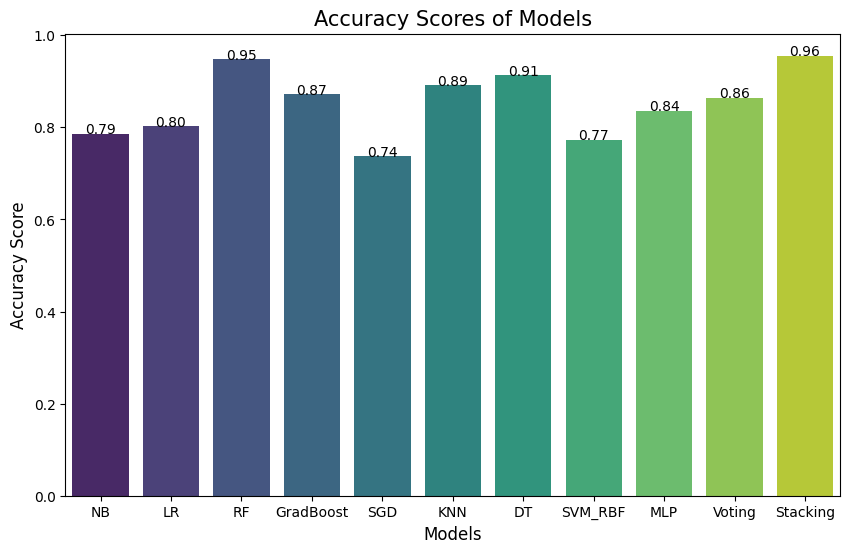

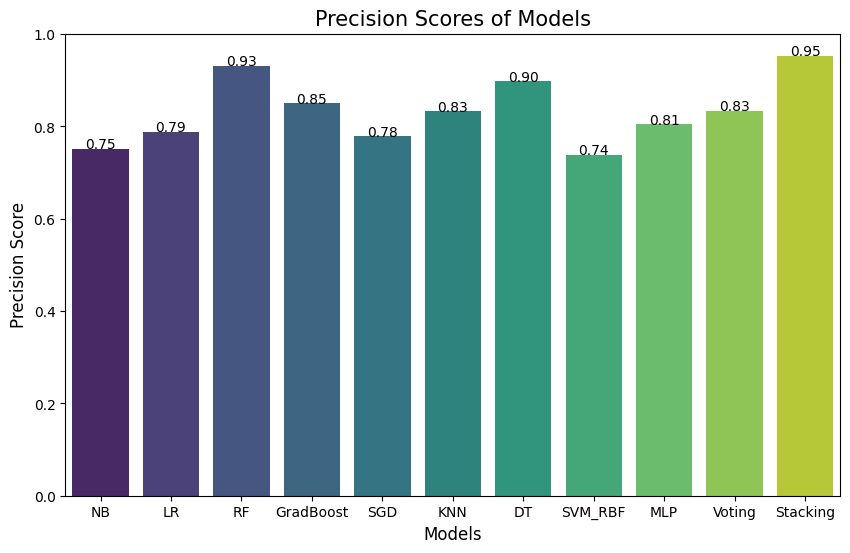

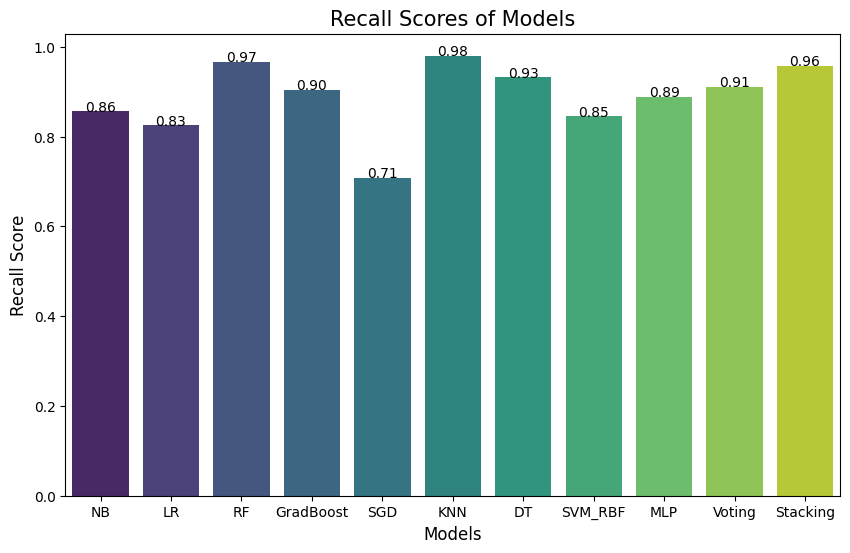

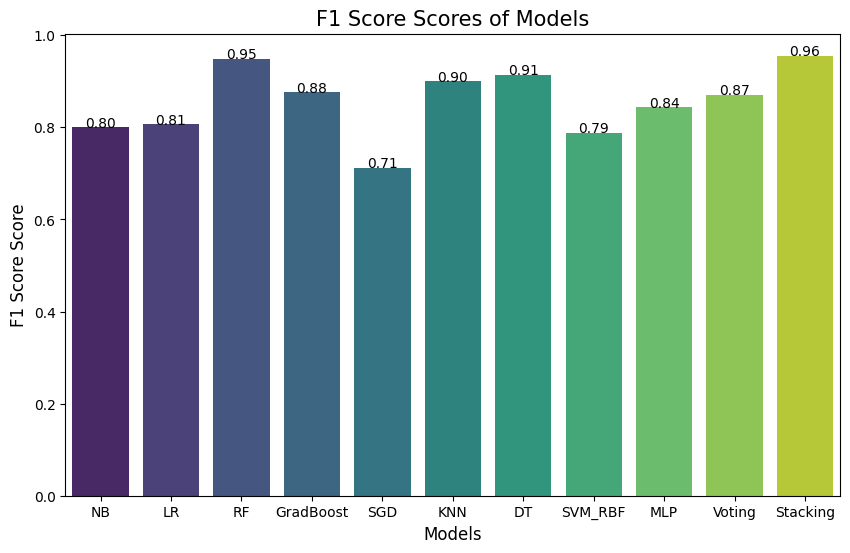

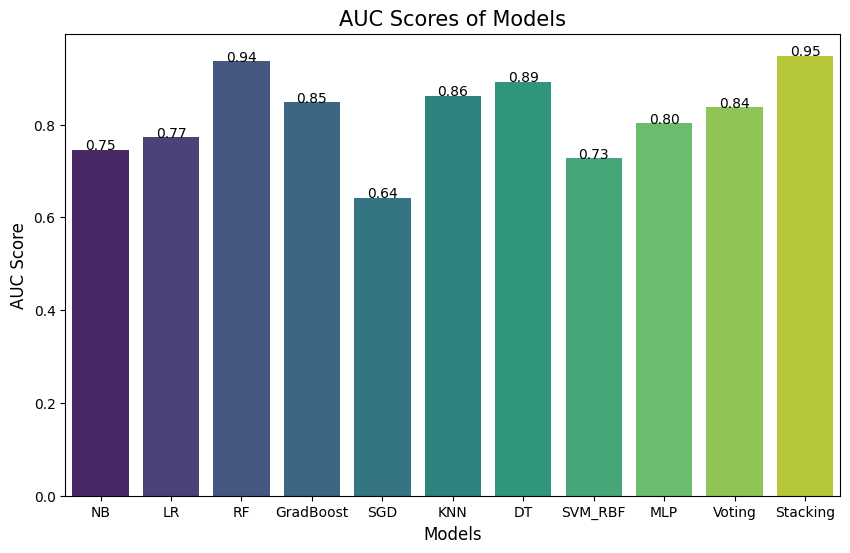

In [9]:
# Plotting histograms for each metric
def plot_metric_histogram(metric_name, results):
    values = [res[metric_name] for res in results.values()]
    models = list(results.keys())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(y=values, x=models, palette='viridis')
    plt.title(f'{metric_name} Scores of Models', fontsize=15)
    plt.ylabel(f'{metric_name} Score', fontsize=12)
    plt.xlabel('Models', fontsize=12)
    for index, value in enumerate(values):
        plt.text(index, value, f'{value:.2f}', ha='center') 
    plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
for metric in metrics:
    plot_metric_histogram(metric, results)

In [10]:
rf_classifier = RandomForestClassifier()  # You can adjust hyperparameters as needed

# Fit the Random Forest classifier to your data
rf_classifier.fit(X_resampled, y_resampled)

# Get feature importances
feature_importance = pd.DataFrame(rf_classifier.feature_importances_, index=X.columns, columns=["Feature Importance"])

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Print the sorted feature importance
print(feature_importance)

                   Feature Importance
age                          0.424918
avg_glucose_level            0.187252
bmi                          0.160420
work_type                    0.073315
smoking_status               0.051570
gender                       0.027247
Residence_type               0.026869
ever_married                 0.020750
hypertension                 0.015827
heart_disease                0.011832


In [11]:
selected_columns = feature_importance[feature_importance["Feature Importance"] >= 0.05].index
X_filtered = X_resampled[selected_columns]
X_filtered_resampled, y_filtered_resampled = smote.fit_resample(X_filtered, y_resampled)

NB: {'Accuracy': 0.7922269591734021, 'Precision': 0.7519490202620358, 'Recall': 0.8724846231162422, 'F1 Score': 0.8076529557207313, 'AUC': 0.7539054643137313}
LR: {'Accuracy': 0.782963576228964, 'Precision': 0.7596032533493458, 'Recall': 0.8274426175188271, 'F1 Score': 0.791931923072705, 'AUC': 0.7465710059388582}
RF: {'Accuracy': 0.9400333701292933, 'Precision': 0.922169409307054, 'Recall': 0.9612953455854022, 'F1 Score': 0.9412638562584095, 'AUC': 0.9239040453982985}
GradBoost: {'Accuracy': 0.8500316149197044, 'Precision': 0.8235194870414544, 'Recall': 0.8911497864378211, 'F1 Score': 0.8558963871009858, 'AUC': 0.822931598134304}
SGD: {'Accuracy': 0.7025218978256549, 'Precision': 0.7063167499490893, 'Recall': 0.6326799930219826, 'F1 Score': 0.6311380718187432, 'AUC': 0.5726966252652483}
KNN: {'Accuracy': 0.8898371250089875, 'Precision': 0.8326147954059098, 'Recall': 0.9759482131683141, 'F1 Score': 0.8985558512620934, 'AUC': 0.8611157421459609}
DT: {'Accuracy': 0.9049574097335888, 'Pre

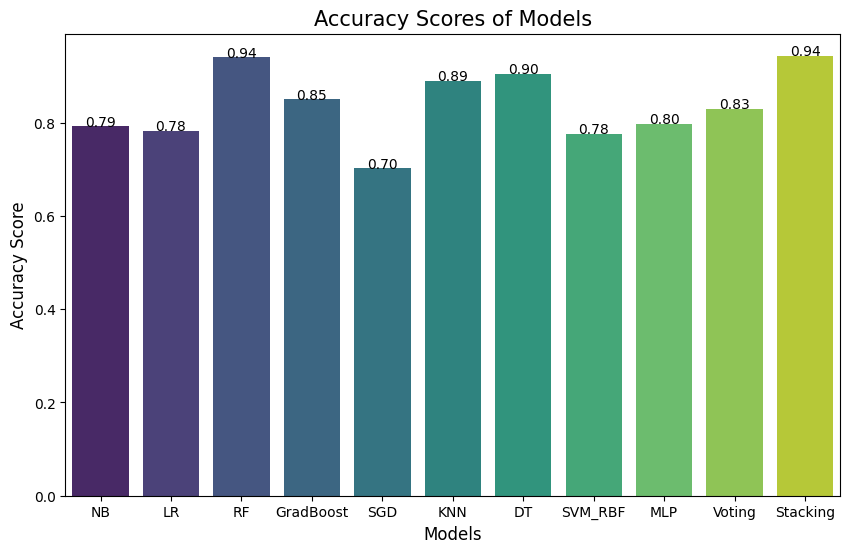

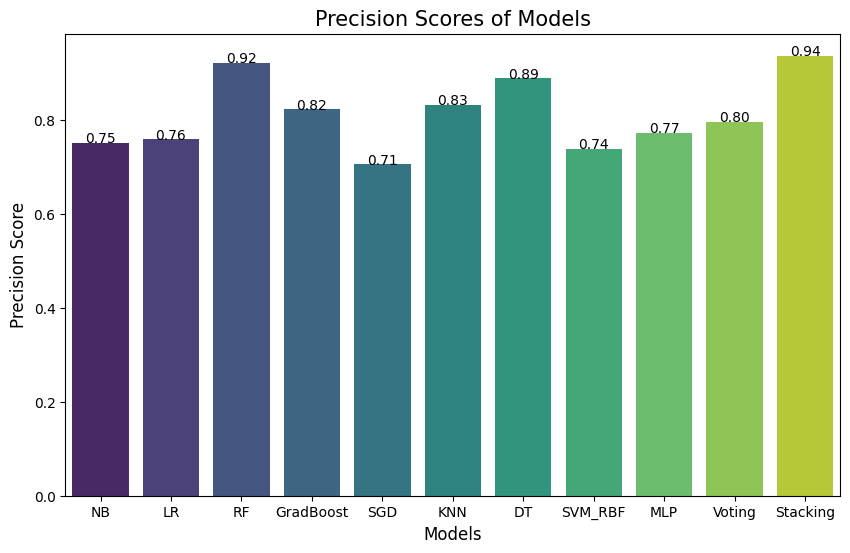

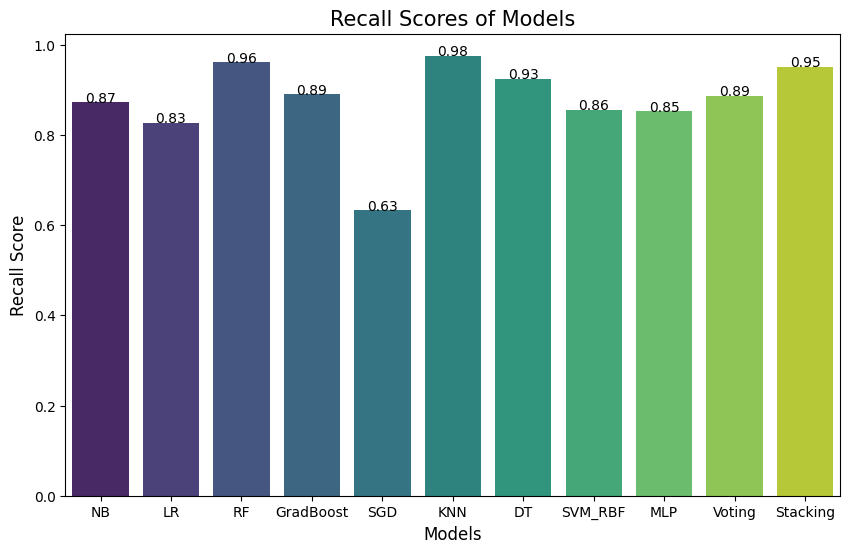

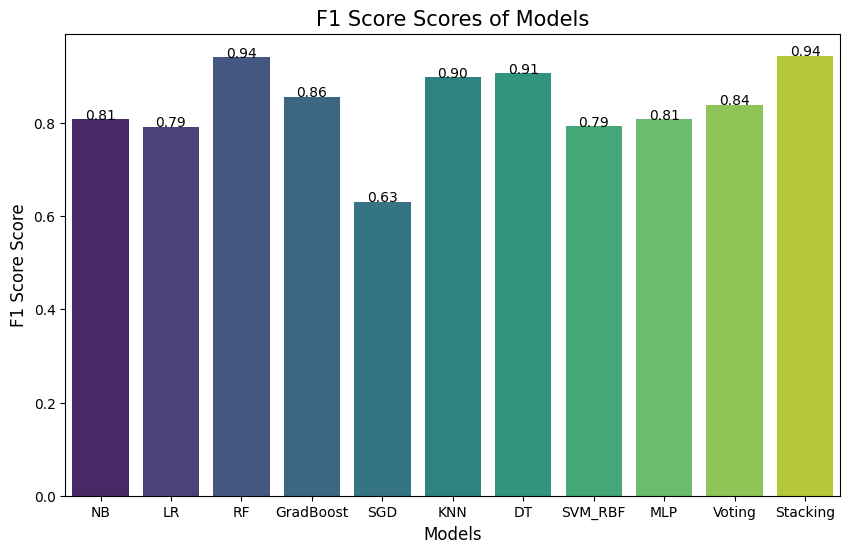

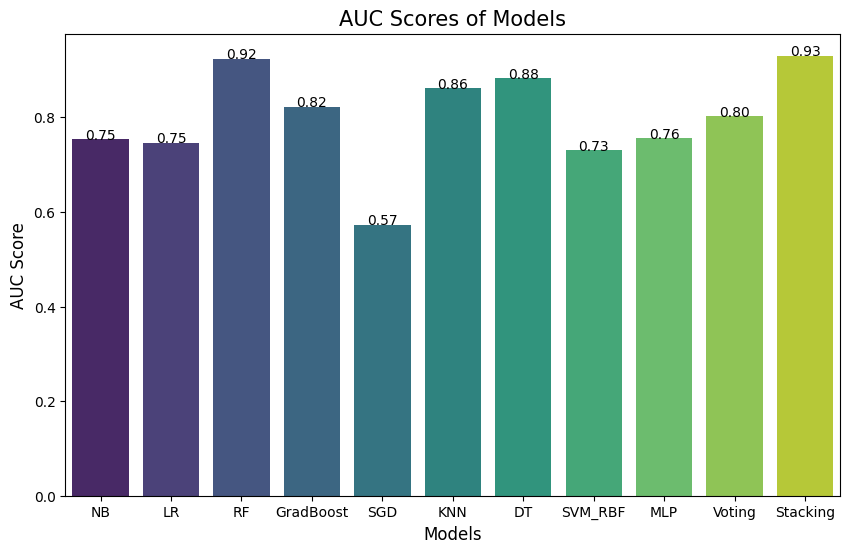

In [12]:
# Evaluating each model with the filtered dataset
results = {name: cross_validate_model(model, X_filtered_resampled, y_filtered_resampled) for name, model in models.items()}

# Display results
for model_name, performance in results.items():
    print(f"{model_name}: {performance}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
for metric in metrics:
    plot_metric_histogram(metric, results)